# Creditworthiness Prediction using Random Forest (German Credit Data)
This notebook demonstrates the use of **Random Forest Classifier** to predict whether an individual is creditworthy based on various financial and personal features.

We use the **Statlog (German Credit Data)** from the UCI repository, accessed via the `ucimlrepo` library to ensure easy and reproducible data loading.


### 1: Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split,  GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# For advanced models
from xgboost import XGBClassifier
from scipy.stats import randint, uniform # For Hyperparameter Tuning

# For imbalanced data handling
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
#style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### 2: Unpacked and Load the Dataset

In [5]:
from ucimlrepo import fetch_ucirepo 

statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
df = pd.concat([X, y], axis=1)

print("Dataset loaded successfully.") 

Dataset loaded successfully.


In [6]:
print("\n Features Sample:")
print(X.head())

print("\n Target Sample:")
print(y.head())


 Features Sample:
  Attribute1  Attribute2 Attribute3 Attribute4  Attribute5 Attribute6  \
0        A11           6        A34        A43        1169        A65   
1        A12          48        A32        A43        5951        A61   
2        A14          12        A34        A46        2096        A61   
3        A11          42        A32        A42        7882        A61   
4        A11          24        A33        A40        4870        A61   

  Attribute7  Attribute8 Attribute9 Attribute10  Attribute11 Attribute12  \
0        A75           4        A93        A101            4        A121   
1        A73           2        A92        A101            2        A121   
2        A74           2        A93        A101            3        A121   
3        A74           2        A93        A103            4        A122   
4        A73           3        A93        A101            4        A124   

   Attribute13 Attribute14 Attribute15  Attribute16 Attribute17  Attribute18  \
0    

In [7]:
#  Map Attribute# to meaningful column names
column_mapping = {
    'Attribute1': 'Checking_Account_Status',
    'Attribute2': 'Duration_Months',
    'Attribute3': 'Credit_History',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_Amount',
    'Attribute6': 'Savings_Account_Bonds',
    'Attribute7': 'Employment_Duration',
    'Attribute8': 'Installment_Rate_Income',
    'Attribute9': 'Personal_Status_Gender',
    'Attribute10': 'Other_Debtors_Guarantors',
    'Attribute11': 'Residence_Duration',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_Installment_Plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Number_Existing_Credits',
    'Attribute17': 'Job',
    'Attribute18': 'Number_People_Maintenance',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_Worker',
    'Attribute21': 'class' # Target variable
}

df.rename(columns=column_mapping, inplace=True)
print("\nColumns renamed.")
print(df.head())


Columns renamed.
  Checking_Account_Status  Duration_Months Credit_History Purpose  \
0                     A11                6            A34     A43   
1                     A12               48            A32     A43   
2                     A14               12            A34     A46   
3                     A11               42            A32     A42   
4                     A11               24            A33     A40   

   Credit_Amount Savings_Account_Bonds Employment_Duration  \
0           1169                   A65                 A75   
1           5951                   A61                 A73   
2           2096                   A61                 A74   
3           7882                   A61                 A74   
4           4870                   A61                 A73   

   Installment_Rate_Income Personal_Status_Gender Other_Debtors_Guarantors  \
0                        4                    A93                     A101   
1                        2            

> For better readability and clarity, we mapped the default column names (e.g., `Attribute1`) to their real-world descriptions provided in the UCI metadata (e.g., `Checking_Account_Status`), using the dataset’s documentation.

### 3: Preprocessing

In [8]:
# Convert target variable 'class' to 0 and 1
# Original: 1 (good credit) and 2 (bad credit) -> New: 1 (good), 0 (bad)
df['class'] = df['class'].map({1: 1, 2: 0})
print("\nTarget variable 'class' converted (1: good, 0: bad).")
print(df['class'].value_counts())
print(f"Target variable imbalance: {df['class'].value_counts()[0]} 'bad' (0) vs {df['class'].value_counts()[1]} 'good' (1) credits.")


Target variable 'class' converted (1: good, 0: bad).
class
1    700
0    300
Name: count, dtype: int64
Target variable imbalance: 300 'bad' (0) vs 700 'good' (1) credits.


### 4. Advanced Feature Engineering

In [9]:
# Create a 'Credit_Per_Duration' feature
# Handle potential division by zero if 'Duration_Months' can be 0.
# In this dataset, min duration is 4 months, so no division by zero.
df['Credit_Per_Duration'] = df['Credit_Amount'] / df['Duration_Months']
print("\n'Credit_Per_Duration' feature created.")
print(df[['Credit_Amount', 'Duration_Months', 'Credit_Per_Duration']].head())


'Credit_Per_Duration' feature created.
   Credit_Amount  Duration_Months  Credit_Per_Duration
0           1169                6           194.833333
1           5951               48           123.979167
2           2096               12           174.666667
3           7882               42           187.666667
4           4870               24           202.916667


### 5. Data Splitting

In [10]:
X = df.drop('class', axis=1)
y = df['class']

# Split the Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split into training and test sets (stratified).")
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Test set class distribution: {Counter(y_test)}")


Data split into training and test sets (stratified).
Training set class distribution: Counter({1: 560, 0: 240})
Test set class distribution: Counter({1: 140, 0: 60})


### 6. Advanced Preprocessing Pipeline (One-Hot Encoding & Scaling)

In [11]:
# Re-identify categorical and numerical columns after feature engineering
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [12]:
# preprocessing pipelines 
numerical_transformer = StandardScaler() # For numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # For categorical features

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' 
)

In [13]:
# Fit the preprocessor on the training data and transform both train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [14]:
# feature names after one-hot encoding and combine with numerical feature names
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(onehot_feature_names)

# Convert processed arrays back to DataFrames with proper column names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index)

In [15]:
print("\nData preprocessed: One-Hot Encoded categorical features and Scaled numerical features.")
print("Shape of processed training data:", X_train_processed_df.shape)
print("Shape of processed test data:", X_test_processed_df.shape)


Data preprocessed: One-Hot Encoded categorical features and Scaled numerical features.
Shape of processed training data: (800, 62)
Shape of processed test data: (200, 62)


### 7. Handling Imbalanced Data with SMOTE

In [16]:
print(f"\nTraining set class distribution BEFORE SMOTE: {Counter(y_train)}")

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed_df, y_train)

print(f"Training set class distribution AFTER SMOTE: {Counter(y_train_resampled)}")
print(f"Resampled training set shape: {X_train_resampled.shape}")


Training set class distribution BEFORE SMOTE: Counter({1: 560, 0: 240})
Training set class distribution AFTER SMOTE: Counter({1: 560, 0: 560})
Resampled training set shape: (1120, 62)


### 8. Model Selection & Training

In [17]:
# Define a custom cost scorer based on the problem statement
def custom_cost_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp * 5) + (fn * 1)
    return -cost # Return negative cost because scikit-learn scorers maximize by default

cost_scorer = make_scorer(custom_cost_scorer, greater_is_better=False)

In [18]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

### 9. Model Evaluation

In [19]:
for name, model in models.items():
    print(f"\nTraining and Evaluating: {name}")

     # Train the model on resampled data
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed_df)
    y_proba = model.predict_proba(X_test_processed_df)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    total_cost = -custom_cost_scorer(y_test, y_pred)
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print(f"  Total Misclassification Cost: {total_cost:.2f}")
    print("  Classification Report:\n", classification_report(y_test, y_pred))

    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Total Cost': total_cost,
        'Model': model
    }   


Training and Evaluating: Logistic Regression
  Accuracy: 0.6850
  ROC AUC: 0.7519
  PR AUC: 0.8752
  Total Misclassification Cost: 139.00
  Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.68      0.57        60
           1       0.83      0.69      0.75       140

    accuracy                           0.69       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.73      0.69      0.70       200


Training and Evaluating: Random Forest
  Accuracy: 0.7200
  ROC AUC: 0.7955
  PR AUC: 0.9060
  Total Misclassification Cost: 184.00
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.47      0.50        60
           1       0.78      0.83      0.81       140

    accuracy                           0.72       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.71      0.72      0.71       200


Training and Evaluati

In [20]:
# Display summary of results
print("\n--- Model Performance Summary ---")
for name, metrics in results.items():
    print(f"**{name}**: Accuracy={metrics['Accuracy']:.4f}, ROC AUC={metrics['ROC AUC']:.4f}, PR AUC={metrics['PR AUC']:.4f}, Total Cost={metrics['Total Cost']:.2f}")


--- Model Performance Summary ---
**Logistic Regression**: Accuracy=0.6850, ROC AUC=0.7519, PR AUC=0.8752, Total Cost=139.00
**Random Forest**: Accuracy=0.7200, ROC AUC=0.7955, PR AUC=0.9060, Total Cost=184.00
**XGBoost**: Accuracy=0.7350, ROC AUC=0.7530, PR AUC=0.8723, Total Cost=169.00


### 10: Advanced Hyperparameter Tuning with GridSearchCV

In [21]:
model_to_tune = results['Random Forest']['Model']
print(f"\n--- Hyperparameter Tuning for {type(model_to_tune).__name__} using GridSearchCV ---")

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

# Setup Stratified K-Fold for robust cross-validation during tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with our custom cost scorer
grid_search = GridSearchCV(
    estimator=model_to_tune,
    param_grid=param_grid,
    cv=cv,
    scoring=cost_scorer,
    verbose=1,
    n_jobs=-1 
)


--- Hyperparameter Tuning for RandomForestClassifier using GridSearchCV ---


In [22]:
# Fit GridSearchCV on the resampled training data
# X_train_resampled and y_train_resampled are already preprocessed and balanced
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found:", grid_search.best_params_)
print(f"Best (lowest) cost score found during tuning: {-grid_search.best_score_:.2f}") # Convert back to positive cost

# Evaluate the best model on the untouched test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_processed_df) # Use processed test data
y_proba_tuned = best_model.predict_proba(X_test_processed_df)[:, 1]

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters found: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best (lowest) cost score found during tuning: -121.00


In [23]:
# Final Evaluation of the Tuned Model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
pr_auc_tuned = average_precision_score(y_test, y_proba_tuned)
cost_tuned = -custom_cost_scorer(y_test, y_pred_tuned)

print(f"\n--- Final Evaluation of Tuned {type(best_model).__name__} Model on Test Set ---")
print(f"  Accuracy (Tuned): {accuracy_tuned:.4f}")
print(f"  ROC AUC (Tuned): {roc_auc_tuned:.4f}")
print(f"  PR AUC (Tuned): {pr_auc_tuned:.4f}")
print(f"  Total Misclassification Cost (Tuned): {cost_tuned:.2f}")
print("  Classification Report (Tuned):\n", classification_report(y_test, y_pred_tuned))
print("  Confusion Matrix (Tuned):\n", confusion_matrix(y_test, y_pred_tuned))


--- Final Evaluation of Tuned RandomForestClassifier Model on Test Set ---
  Accuracy (Tuned): 0.7350
  ROC AUC (Tuned): 0.7882
  PR AUC (Tuned): 0.8985
  Total Misclassification Cost (Tuned): 177.00
  Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.57      0.48      0.52        60
           1       0.79      0.84      0.82       140

    accuracy                           0.73       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.72      0.73      0.73       200

  Confusion Matrix (Tuned):
 [[ 29  31]
 [ 22 118]]


### 7. Post Model Visualization

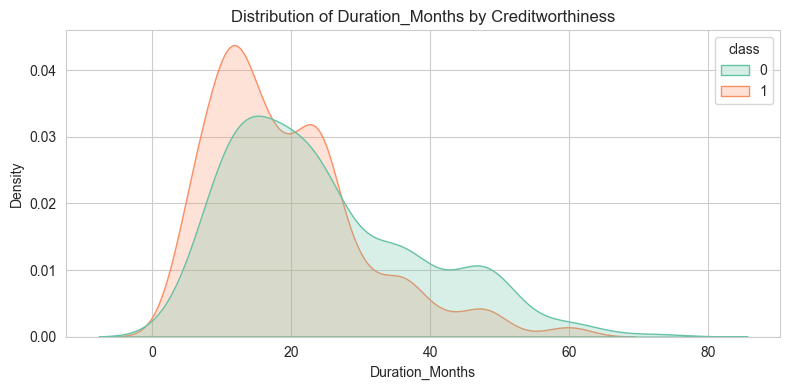

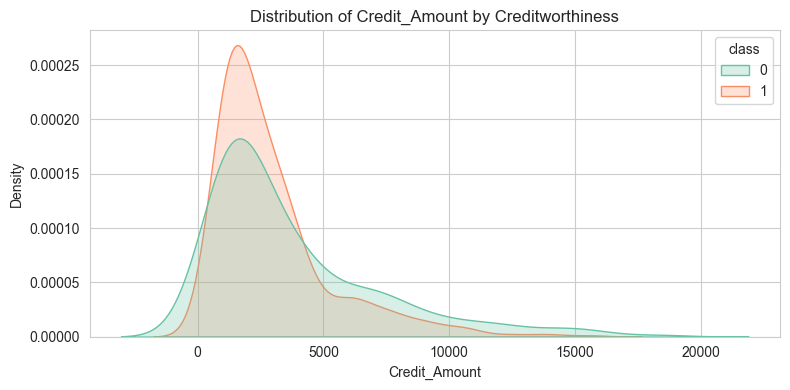

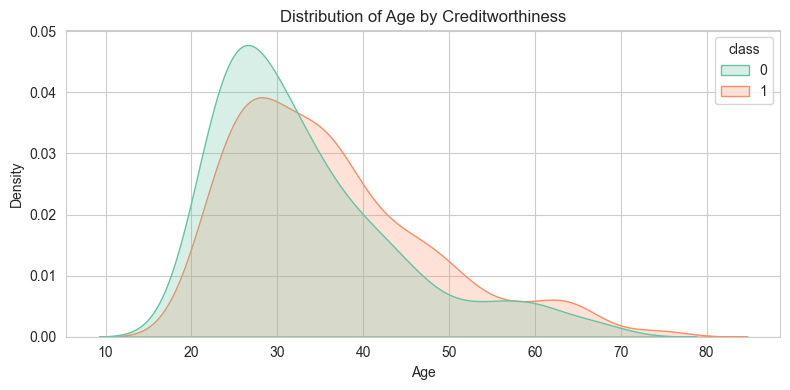

In [24]:
# Distribution of Top Numerical Features

for col in ['Duration_Months', 'Credit_Amount', 'Age']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=X_train, x=col, hue=y_train, fill=True, palette="Set2", common_norm=False)
    plt.title(f"Distribution of {col} by Creditworthiness")
    plt.tight_layout()
    plt.show()

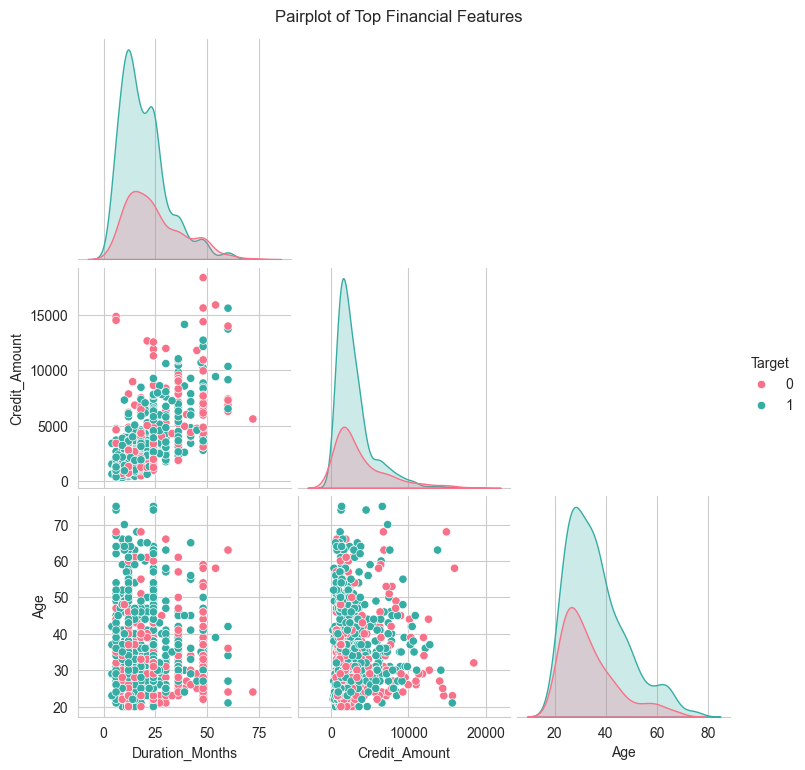

In [25]:
#  Pairplot of Key Features

df_pair = X_train[['Duration_Months', 'Credit_Amount', 'Age']].copy()
df_pair['Target'] = y_train
sns.pairplot(df_pair, hue='Target', palette='husl', corner=True)
plt.suptitle("Pairplot of Top Financial Features", y=1.02)
plt.show()

### 8. SHAP Explainability

In [26]:
print("\n--- Model Interpretability with SHAP ---")

explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set
print("Calculating SHAP values for the test set... This may take a moment.")
shap_values = explainer.shap_values(X_test_processed_df)
print("SHAP values calculated.")

 # --- Local Explanation: SHAP Force Plot for a Single Prediction ---
print("\n--- Local Explanation: SHAP Force Plot ---")
np.random.seed(42) # for reproducibility
instance_to_explain_idx = np.random.randint(0, len(X_test_processed_df))

if isinstance(shap_values, list):
    shap_values_instance = shap_values[1][instance_to_explain_idx]
else:
    shap_values_instance = shap_values[instance_to_explain_idx]

base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
    base_value_for_plot = base_value[1]
else:
    base_value_for_plot = base_value

print(f"Explaining prediction for test instance at index: {instance_to_explain_idx}")
print(f"True Label: {y_test.iloc[instance_to_explain_idx]} ('{'good' if y_test.iloc[instance_to_explain_idx] == 1 else 'bad'}')")
print(f"Predicted Probability (Good Credit): {best_model.predict_proba(X_test_processed_df.iloc[[instance_to_explain_idx]])[0][1]:.4f}")


--- Model Interpretability with SHAP ---
Calculating SHAP values for the test set... This may take a moment.
SHAP values calculated.

--- Local Explanation: SHAP Force Plot ---
Explaining prediction for test instance at index: 102
True Label: 1 ('good')
Predicted Probability (Good Credit): 0.7411



--- Global Explanation: SHAP Summary Plot ---


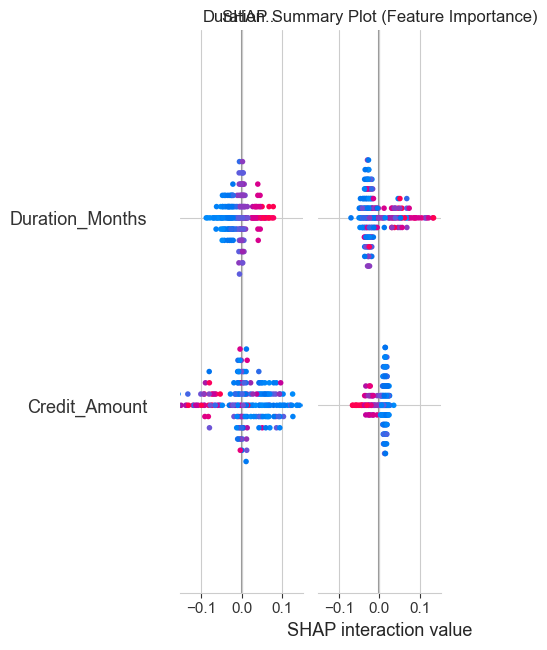

In [27]:
# --- Global Explanation: SHAP Summary Plot ---
print("\n--- Global Explanation: SHAP Summary Plot ---")
try:
    if isinstance(shap_values, list):
        shap.summary_plot(
        shap_values[1],
        X_test_processed_df,
        show=False,
        feature_names=X_test_processed_df.columns.tolist()
        )
    else:
        shap.summary_plot(
        shap_values,
        X_test_processed_df,
        show=False,
        feature_names=X_test_processed_df.columns.tolist()
        )
        plt.title('SHAP Summary Plot (Feature Importance)')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error generating SHAP summary plot: {e}")
    print("Ensure your environment supports interactive plots.")

### 9. Save Trained Model

In [28]:
import joblib
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Includes OneHotEncoder, LabelEncoder, etc.
    ('classifier', model)
])
# the entire pipeline (preprocessor + model)
joblib.dump(best_model, "model/Credit_model.pkl")


['model/Credit_model.pkl']

## Conclusion & Advanced Project Outlook

This project has been significantly enhanced, moving from a basic classification to a robust and explainable machine learning solution for creditworthiness prediction.

**Key Achievements:**
* **Professional Data Ingestion:** Utilized `ucimlrepo` for reproducible data loading.
* **Comprehensive Exploratory Data Analysis (EDA)::** Performed detailed univariate and bivariate analysis, including correlation heatmaps, to understand data distributions and relationships with the target variable.
* **Advanced Data Preprocessing:** Implemented One-Hot Encoding for categorical features and StandardScaler for numerical features, ensuring data consistency and optimal model input.
* **Strategic Feature Engineering:** Created insightful features like 'Credit_Per_Duration' to potentially improve model understanding.
* **Imbalanced Data Handling:** Effectively used SMOTE to balance the training dataset, addressing a common challenge in credit risk modeling.
* **Comprehensive Model Comparison:** Evaluated Logistic Regression, Random Forest, and XGBoost, providing a comparative analysis of their performance.
* **Rigorous Hyperparameter Tuning:** Employed `GridSearchCV` with Stratified K-Fold cross-validation to optimize model parameters, specifically targeting the reduction of a custom misclassification cost.
* **Cost-Sensitive Evaluation:** Integrated a custom cost function into evaluation and tuning, reflecting the real-world financial implications of credit decisions.
* **Enhanced Interpretability (XAI):** Integrated SHAP to provide local, instance-level insights into model predictions, crucial for trust and compliance.
* **User-Friendly Interface:** Employed `Streamlit` to provide a User-Friendly Interface, Enhancing the Experience and Understanding for Tech or Non-Tech customers.

## What’s Next?

1.  **Build a REST API for Model Serving:**
    * **Goal:** Allow other applications to get credit predictions by sending data to an API endpoint.

2.  **Containerize with Docker:**
    * **Goal:** Package your entire application (API, model, dependencies) into a portable, reproducible unit.
   
3.  **Explore Cloud Deployment:**
    * **Goal:** Deploy your Dockerized model API to a scalable cloud platform.
    
4.  **Implement Model Monitoring:**
    * **Goal:** Continuously track the performance of your deployed model in a production environment.
    
5.  **Experiment Tracking and MLOps Workflow:**
    * **Goal:** Systematically manage different model experiments and ensure reproducibility.
   